In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.backend import ones_like
from keras.layers.recurrent import GRU
from keras.layers.core import Lambda
from keras.optimizers import adam
from keras.layers import Conv1D, Dense, Reshape, Concatenate, Flatten, Activation, Dropout,MaxPooling1D
from keras.models import Input, Model
from keras_self_attention import SeqSelfAttention
from keras_multi_head import MultiHeadAttention
import numpy as np
import os
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-pack

In [2]:
from keras import backend as K
from keras.layers import Layer ,Add
from keras.layers.core import Lambda

def local_context_learning(path_length, input_length, input_dim, output_dim, hidden_dim, filters_num, kernel_val,
                           learning_rate, drop_rate):
    basic_data_input = Input(shape=(path_length, input_length, input_dim))

    basic_input = Reshape((path_length, input_length * input_dim))(basic_data_input)
    
    GRU_layer = GRU(units=hidden_dim, return_sequences=True)
    rnn_output = GRU_layer(basic_input)
    Self_1 = SeqSelfAttention(attention_activation='sigmoid')
    rnn_att = Self_1(rnn_output)
    CNN_layer_1 = Conv1D(filters=filters_num, kernel_size=kernel_val, padding="same")
    cnn_output = CNN_layer_1(basic_input)
    Dense_1 = Dense(hidden_dim)
    cnn_output_reformat = Dense_1(cnn_output)
    Self_2 = SeqSelfAttention(attention_activation='sigmoid')
    cnn_att = Self_2(cnn_output_reformat)
    Conca_1 = Concatenate(axis=1)
    new_value = Conca_1([rnn_att, cnn_att])
    new_keys = Lambda(lambda x: ones_like(x))(new_value)
    Multi_1 = MultiHeadAttention(head_num=2)
    new_result = Multi_1([basic_input, new_keys, new_value])
    result = Flatten()(new_result)
    Drop_1 = Dropout(rate=drop_rate)
    result_fix = Drop_1(result)
    Dense_2 = Dense(output_dim)
    method_vector = Dense_2(result_fix)
    method_vector = Reshape((-1, 128))(method_vector)

    CNN_layer_2 = Conv1D(filters=filters_num, kernel_size=kernel_val, padding="same")
    cnn_output_for_classification = CNN_layer_2(method_vector)
    Pool_1 = MaxPooling1D(pool_size=2, padding='same')
    pooling_output = Pool_1(cnn_output_for_classification)
    output_classification = Flatten()(pooling_output)
    Drop_2 = Dropout(rate=drop_rate)
    output_classification_fix = Drop_2(output_classification)
    Dense_3 = Dense(32, activation='relu')
    output_classification_fix = Dense_3(output_classification_fix)
    Dense_4 = Dense(16, activation='relu')
    output_classification_fix = Dense_4(output_classification_fix)
    Dense_5 = Dense(1)
    fixed_output_classification = Dense_5(output_classification_fix)
    Active_1 = Activation(activation='sigmoid')
    stand_output = Active_1(fixed_output_classification)
    model = Model(basic_data_input, stand_output)
    ada = adam(lr=learning_rate)
    model.compile(optimizer=ada, loss='binary_crossentropy', metrics=['accuracy'])

    
    New_input  = Input(shape=(path_length, input_length, input_dim))
    New_input_ = Reshape((path_length, input_length * input_dim))(New_input)
    new_test_1 = GRU_layer(New_input_)
    new_test_2 = Self_1(new_test_1)
    new_test_3 = CNN_layer_1(New_input_)
    new_test_4 = Dense_1(new_test_3)
    new_test_5 = Self_2(new_test_4)
    new_test_6 = Conca_1([new_test_2, new_test_5])
    new_test_7 = Lambda(lambda x: ones_like(x))(new_test_6)
    new_test_8 = Multi_1([New_input_, new_test_7, new_test_6])
    new_test_9 = Flatten()(new_test_8)
    new_test_10 = Drop_1(new_test_9)
    new_test_11 = Dense_2(new_test_10)
    new_test_12 = Reshape((-1, 128))(new_test_11)
    new_test_13 = CNN_layer_2(new_test_12)
    new_test_14 = Pool_1(new_test_13)
    new_test_15 = Flatten()(new_test_14)
    new_test_16 = Drop_2(new_test_15)
    new_test_17 = Dense_3(new_test_16)
    new_test_18 = Dense_4(new_test_17)
    new_test_19 = Dense_5(new_test_18)
    new_test_20 = Active_1(new_test_19)
    model_test = Model(New_input, new_test_20)
    return model, model_test

In [3]:
model_local, model_local_test = local_context_learning(15, 20, 128, 128, 128, 64, 3, 0.0001, 0.5)
model_local.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 20, 128)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 15, 2560)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15, 64)       491584      reshape_1[0][0]                  
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 15, 128)      1032576     reshape_1[0][0]                

In [4]:
def getting_data(file_path, print_text):
    print("Loading " + print_text + " Data...")
    data = np.load(file_path,allow_pickle = True)
    print("Done")
    return data

In [5]:
input_data = getting_data("./data/local_train_input_greedy.npy", "Input")
label_data = getting_data("./data/local_train_label_greedy.npy", "Label")
output_data = getting_data("./data/local_train_output_greedy.npy", "Output")
label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [6]:
label_data.shape

(7109, 15)

In [7]:
v_input_data = getting_data("./data/local_val_input_greedy.npy", "Input")
v_label_data = getting_data("./data/local_val_label_greedy.npy", "Label")
v_output_data = getting_data("./data/local_val_output_greedy.npy", "Output")
v_label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [8]:
v_label_data.shape

(2370, 15)

In [9]:
print("Training Local Context Model...")
model_local.fit(input_data, output_data, batch_size=256, epochs=100,validation_data=(v_input_data, v_output_data))

Training Local Context Model...

Train on 7109 samples, validate on 2370 samples
Epoch 1/100
7109/7109 [==============================] - 14s 2ms/step - loss: 0.6906 - accuracy: 0.5151 - val_loss: 0.6871 - val_accuracy: 0.5641
Epoch 2/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.6841 - accuracy: 0.5807 - val_loss: 0.6758 - val_accuracy: 0.6051
Epoch 3/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.6748 - accuracy: 0.6044 - val_loss: 0.6663 - val_accuracy: 0.6148
Epoch 4/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.6613 - accuracy: 0.6154 - val_loss: 0.6559 - val_accuracy: 0.6346
Epoch 5/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.6532 - accuracy: 0.6309 - val_loss: 0.6441 - val_accuracy: 0.6392
Epoch 6/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.6394 - accuracy: 0.6492 - val_loss: 0.6393 - val_accuracy: 0.6447
Epoch 7/100
7109/7109 [====================

Epoch 55/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.2843 - accuracy: 0.8693 - val_loss: 0.9749 - val_accuracy: 0.6785
Epoch 56/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.2970 - accuracy: 0.8630 - val_loss: 0.9588 - val_accuracy: 0.6806
Epoch 57/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.2883 - accuracy: 0.8654 - val_loss: 1.0341 - val_accuracy: 0.6785
Epoch 58/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.2769 - accuracy: 0.8671 - val_loss: 0.9984 - val_accuracy: 0.6717
Epoch 59/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.2770 - accuracy: 0.8728 - val_loss: 1.0230 - val_accuracy: 0.6962
Epoch 60/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.2683 - accuracy: 0.8755 - val_loss: 1.0114 - val_accuracy: 0.6671
Epoch 61/100
7109/7109 [==============================] - 11s 2ms/step - loss: 0.2835 - accuracy: 0.8699 - val_loss: 1

In [10]:
model_local.save('model_greedy_train.h5')
model_local_test.save('model_greedy_test.h5')

In [11]:
t_input_data = getting_data("./data/local_test_input_greedy.npy", "Input")
t_output_data = getting_data("./data/local_test_output_greedy.npy", "Output")

Loading Input Data...
Done
Loading Output Data...
Done


In [12]:
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [13]:
y_predict = model_local_test.predict(t_input_data)

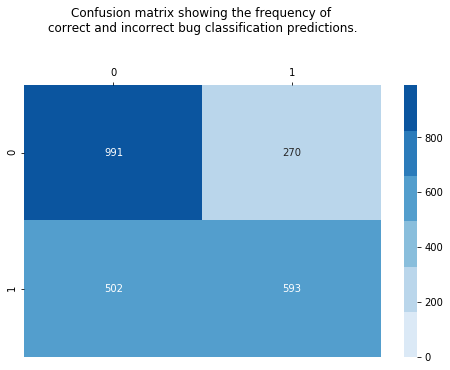

In [14]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(t_output_data, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [15]:
from sklearn.metrics import  auc, roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(t_output_data, y_predict)
precision, recall, thresholds = precision_recall_curve(t_output_data, y_predict)

In [16]:
import matplotlib.pyplot as plt

auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(t_output_data, y_predict)
pr_auc = auc(recall, precision)
f1 = f1_score(t_output_data, np.rint(y_predict))
mcc = matthews_corrcoef(t_output_data, np.rint(y_predict))

In [17]:
print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.698
ROC AUC: 0.698
MCC: 0.339
F1: 0.606


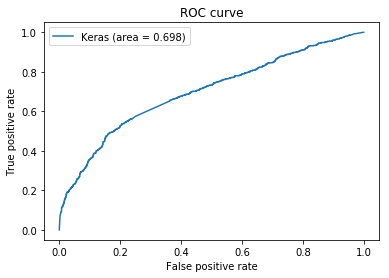

In [18]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [19]:
tn, fp, fn, tp = metrics.confusion_matrix(
    t_output_data.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)
r = tp/(tp+fn)
p = tp/(tp+fp)
f = (2*p*r)/(p+r)
acc = (tp+tn)/(tp+fp+fn+tn)

In [20]:
print("fpr_nn",fpr_nn)
print("fnr_nn",fnr_nn)
print("r",r)
print("p",p)
print("f",f)
print("acc",acc)

fpr_nn 0.3128621089223638
fnr_nn 0.3362357669122572
r 0.5415525114155251
p 0.6871378910776361
f 0.605720122574055
acc 0.6723259762308998


In [21]:
best_f1 = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if f>best_f1:
        best_f1 = f
        print(r,p,f,acc,predict)

0.5744292237442923 0.6663135593220338 0.6169691025012262 0.6685059422750425 [0.3431539]
0.7799086757990867 0.5357590966122961 0.6351803644477502 0.583616298811545 [0.02174029]
0.8237442922374429 0.518688901667625 0.6365561044460126 0.5628183361629882 [0.00664994]
0.9315068493150684 0.49586776859504134 0.6472081218274113 0.5280135823429541 [0.00014588]
0.9296803652968036 0.4968277208394339 0.6475826972010178 0.5297113752122241 [0.00016353]


In [22]:
best_r = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if r>best_r:
        best_r = r
        print(r,p,f,acc,predict)

0.5744292237442923 0.6663135593220338 0.6169691025012262 0.6685059422750425 [0.3431539]
0.7799086757990867 0.5357590966122961 0.6351803644477502 0.583616298811545 [0.02174029]
0.8237442922374429 0.518688901667625 0.6365561044460126 0.5628183361629882 [0.00664994]
0.9315068493150684 0.49586776859504134 0.6472081218274113 0.5280135823429541 [0.00014588]
0.9579908675799087 0.48075160403299727 0.6402197131522734 0.49957555178268254 [1.2427568e-05]
0.9899543378995433 0.47130434782608693 0.6385861561119294 0.4792020373514431 [8.940697e-08]
0.9926940639269406 0.47056277056277057 0.6384728340675477 0.47750424448217316 [5.9604645e-08]
0.993607305936073 0.4691677447175507 0.6373755125951962 0.47453310696095075 [0.]


In [23]:
best_a = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if acc>best_a:
        best_a = acc
        print(r,p,f,acc,predict)

0.5744292237442923 0.6663135593220338 0.6169691025012262 0.6685059422750425 [0.3431539]
0.5388127853881278 0.6876456876456877 0.6041986687147977 0.6719015280135824 [0.51494247]
0.536986301369863 0.6925795053003534 0.6049382716049383 0.6740237691001698 [0.5318167]
0.4894977168949772 0.721399730820996 0.5832426550598477 0.6748726655348047 [0.756737]
0.4931506849315068 0.72 0.5853658536585366 0.6752971137521222 [0.7467081]
0.4894977168949772 0.7233468286099866 0.5838779956427016 0.6757215619694398 [0.75805026]


# imbalance testing

In [24]:
im_t_input_data = getting_data("./data/local_im_test_input_greedy.npy", "Input")
im_t_output_data = getting_data("./data/local_im_test_output_greedy.npy", "Output")

Loading Input Data...
Done
Loading Output Data...
Done


In [25]:
y_im_predict = model_local.predict(im_t_input_data)

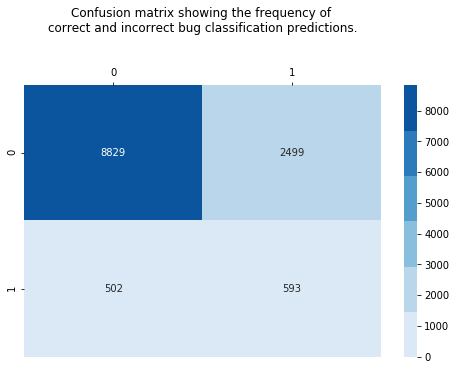

In [26]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(im_t_output_data, np.rint(y_im_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [27]:
tn, fp, fn, tp = metrics.confusion_matrix(
    im_t_output_data.astype(int), 
    np.rint(y_im_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)
r = tp/(tp+fn)
p = tp/(tp+fp)
f = (2*p*r)/(p+r)
acc = (tp+tn)/(tp+fp+fn+tn)

In [28]:
print("fpr_nn",fpr_nn)
print("fnr_nn",fnr_nn)
print("r",r)
print("p",p)
print("f",f)
print("acc",acc)

fpr_nn 0.8082147477360931
fnr_nn 0.05379916407673347
r 0.5415525114155251
p 0.19178525226390686
f 0.2832577024122283
acc 0.7584319407550512


In [29]:
best_f1 = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if f>best_f1:
        best_f1 = f
        print(r,p,f,acc,predict)

0.5662100456621004 0.17260579064587972 0.26456155323234476 0.7225307896643323 [0.3431539]
0.31232876712328766 0.24358974358974358 0.27370948379351745 0.8539000241487563 [0.98638904]
0.4575342465753425 0.21782608695652175 0.295139911634757 0.8073734202688562 [0.8432565]
0.4639269406392694 0.21774539219888556 0.29638273045507585 0.8058439990340498 [0.83409274]
0.46301369863013697 0.21806451612903227 0.29649122807017547 0.8063269741608308 [0.8365201]


In [30]:
best_a = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if acc>best_a:
        best_a = acc
        print(r,p,f,acc,predict)

0.7095890410958904 0.12388392857142858 0.21094068141713046 0.5320775980037028 [0.10669652]
0.536986301369863 0.19373970345963756 0.2847457627118644 0.7622152459148354 [0.5337529]
0.4611872146118721 0.21823681936041486 0.29627456732179525 0.8068904451420752 [0.84090924]
0.4 0.2283628779979145 0.2907401261201461 0.8279803590115109 [0.9374236]
0.12420091324200913 0.3665768194070081 0.1855388813096862 0.9038879497705868 [0.99998164]
0.1232876712328767 0.3935860058309038 0.1877607788595271 0.9059808419866376 [0.9999876]
0.07671232876712329 0.5283018867924528 0.1339712918660287 0.9125815020526443 [0.9999999]


In [31]:
best_r = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if r>best_r:
        best_r = r
        print(r,p,f,acc,predict)

0.7095890410958904 0.12388392857142858 0.21094068141713046 0.5320775980037028 [0.10669652]
0.8438356164383561 0.10456037116668553 0.1860652436568667 0.34927151251710536 [0.0038971]
0.9242009132420091 0.09782503624939584 0.1769230769230769 0.24205103437172987 [0.00019336]
0.9789954337899544 0.09138180888244822 0.16716045532512086 0.14014328262094503 [1.1324883e-06]
0.993607305936073 0.08933409967977667 0.16392948621365075 0.10665700716413105 [0.]
